In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

### 1. Overall return 

In [1]:
import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    

def build_query(start_date=None, end_date=None, index_id=None):
    query = {}
    def parse_date(x):
        if type(x) == int:
            return x
        elif type(x) == str:
            if len(x) != 8:
                raise Exception("date must be YYYYMMDD format")
            return int(x)
        elif type(x) == datetime.datetime or type(x) == datetime.date:
            return x.strftime("%Y%m%d").astype(int)
        else:
            raise Exception("invalid date type: " + str(type(x)))
    if start_date is not None or end_date is not None:
        query['date'] = {}
        if start_date is not None:
            query['date']['$gte'] = parse_date(start_date)
        if end_date is not None:
            query['date']['$lte'] = parse_date(end_date)
    def parse_symbol(x):
        if type(x) == int:
            return x
        else:
            return int(x)
    if index_id:
        if type(index_id) == list or type(index_id) == tuple:
            query['index_id'] = {'$in': [parse_symbol(x) for x in index_id]}
        else:
            query['index_id'] = parse_symbol(index_id)
    return query

def write_memb_data(db, name, df):
    collection = db[name]
    df1 = []
    for symbol in df['index_id'].unique():
        if symbol in collection.distinct('index_id'):
            symbol = int(symbol)
            m_ax = pd.DataFrame.from_records(collection.find({'index_id':{'$in':[symbol]}}).sort([('date',-1)]).skip(0).limit(1))['date'].values[0]
            df2 = df[(df['index_id'] == symbol) & (df['date'] > m_ax)]
            print(df2)
            df1 += [df2]
        else:
            print(symbol)
            df2 = df[(df['index_id'] == symbol)]
            print(df2)
            df1 += [df2]
    df1 = pd.concat(df1).reset_index(drop=True)
    df1 = df1.to_dict('records')
    collection.insert_many(df1) 

def delete_memb_data(db, name, start_date=None, end_date=None, index_id=None):
    collection = db[name]
    query = build_query(start_date, end_date, index_id)
    if not query:
        print('cannot delete the whole table')
        return None
    collection.delete_many(query)  


database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)

In [4]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML
startDate = '20200801'
endDate = '20201030'

readPath = "L:\\orderLog\\ret\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
df = []
add = read_memb_daily(db1, 'index_memb', int(startDate), int(endDate), index_id=[1000300, 1000905, 1000852, 1000985])
add = add.rename(columns={'skey':'secid'})

dateLs = np.sort(dateLs)
dataPathLs = np.sort(dataPathLs)
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]
    data = data.sort_values(by=['order', 'innerSeq'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data[data['secid'].isin(add['secid'].unique())]
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where(data["orderDirection"].isin([1, 2]), 1, 0)
    data["sellNum"] = np.where(data["orderDirection"].isin([-1, -2]), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)

print('2. Orders with nan ars in updateType 0')
if df[df['ars'].isnull()].shape[0] != 0:
    print(df[df['ars'].isnull()])
    df = df[~df['ars'].isnull()]
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000

print('3. Current strategy status')
if 2 in df['mrstauc'].unique():
    print(df[df['mrstauc'] == 2].groupby('mrstaat')['mrstauc'].unique())
    df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
print(df.groupby('mrstaat')['mrstauc'].unique())

print('4. Strange strategy')
if df[(df["mrstaat"].isnull()) | (df['mrstaat'] == 0) | (df['mrstaat'] == 2000)].shape[0] != 0:
    print('1) null mrstaat value')
    print(df[(df["mrstaat"].isnull())][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print(df[(df["mrstaat"].isnull())].groupby(['date', 'colo', 'accCode'])['secid'].size())
    print('2) 0 mrstaat value')
    print(df[(df["mrstaat"] == 0)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('3) 2000 mrstaat value')
    print(df[(df["mrstaat"] == 2000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000)]

if 'mrsb90' in df.columns:
    df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
    df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
    df = df[df['mrsb90'] != '-']
    df['mrsb90'] = df['mrsb90'].astype(float)
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']   

df = pd.merge(df, add[['date', 'secid', 'index_name']], on=['date', 'secid'], how='left')
# os.mkdir('L:\\orderLog\\monthly return\\' + startDate[:6])
df['tag'] = np.where(df['date'] <= 20200831, 202008, np.where(
df['date'] <= 20200930, 202009, 202010))

1. Loading Data 20200803
There are stocks with zero trade size
colo      accCode
zt_88_02  8854        6
zt_88_03  8943       15
          8970       33
          8971       43
          897002      6
Name: secid, dtype: int64
1. Loading Data 20200804
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       17
zt_88_03  8943       17
          8970       46
          8971       54
          897002      4
Name: secid, dtype: int64
1. Loading Data 20200805
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       10
zt_88_03  8943       12
          8970       24
          8971       31
          897002      4
Name: secid, dtype: int64
1. Loading Data 20200806
There are stocks with zero trade size
colo      accCode
zs_88_04  8865        2
zt_88_02  8854       18
zt_88_03  8943       12
          8970       32
          8971       39
          897002      3
Name: secid, dtype: int64
1. Loading Data 20200807
There are stocks with zero trade size
colo 

1. Loading Data 20200921
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       26
          8886       69
zt_88_03  8943       26
          8970       53
          8971       56
          897002     11
Name: secid, dtype: int64
1. Loading Data 20200922
There are stocks with zero trade size
colo      accCode
zs_88_04  8865        1
zt_88_02  8854       22
          8886       74
zt_88_03  8943       29
          8970       58
          8971       90
          897002     10
Name: secid, dtype: int64
1. Loading Data 20200923
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       10
          8886       35
zt_88_03  8943       34
          8970       43
          8971       61
          897002      4
Name: secid, dtype: int64
1. Loading Data 20200924
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       15
          8886       58
zt_88_03  8943       23
          8970       43
          8971       51
          897002      

In [22]:
# Taking/ Making orders
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]
df1 = df.copy()
df1['order_type'] = np.where(df1['ars']%10 == 1, 'taking_order', 'making_order')

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "order_type"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "order_type"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["sellNum"].transform(sum)

# df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index().to_csv('L:\\orderLog\\monthly return\\' + startDate[:6] + '\\taking_making.csv', index=False)
df2 = df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()
from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

In [88]:
(df[(df['tag'] == 202009) & (df['exchange'] == 'SZE') & (df['ars']%10 == 1) & (df['orderDirection'].isin([-1, -2]))].groupby('date')['sellAlpha']\
.describe() * 10000).astype('int64')

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
20200901,236180000,7,39,-557,-5,6,19,644
20200902,299100000,7,41,-448,-5,5,21,462
20200903,260300000,10,44,-410,-6,8,28,691
20200904,257230000,7,46,-657,-5,7,25,456
20200907,394930000,6,36,-461,-8,4,19,612
20200908,317530000,8,49,-551,-7,8,28,938
20200909,287520000,8,49,-997,-6,8,27,685
20200910,327820000,12,41,-731,-6,7,26,499
20200911,287670000,8,43,-469,-4,7,23,756


In [85]:
(df[(df['tag'] == 202009) & (df['exchange'] == 'SZE') & (df['ars']%10 == 2) & (df['orderDirection'].isin([-1, -2]))].groupby('date')['sellAlpha']\
.describe() * 10000).astype('int64')

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
20200901,7710000,7,35,-135,-5,5,21,193
20200902,8070000,9,24,-233,-1,8,22,121
20200903,6980000,6,35,-182,-6,6,24,106
20200904,8900000,9,41,-359,-4,9,25,134
20200907,9420000,10,33,-168,-5,8,26,190
20200908,9870000,5,58,-362,-5,9,29,172
20200909,8620000,9,31,-138,-5,12,27,158
20200910,10280000,12,45,-134,-9,6,22,265
20200911,8360000,12,27,-155,-1,10,26,120


In [94]:
(df[(df['tag'] == 202009) & (df['exchange'] == 'SZE') & (df['ars']%10 == 1) & (df['orderDirection'].isin([-1, -2]))]['sellAlpha']\
.describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 10000).astype('int64')

count    14188560000
mean               7
std               38
min             -997
10%              -21
20%               -8
30%               -2
40%                1
50%                6
60%               10
70%               16
80%               24
90%               40
max             1533
Name: sellAlpha, dtype: int64

In [67]:
df[(df['tag'] == 202009) & (df['exchange'] == 'SZE') & (df['ars']%10 == 1) & (df['orderDirection'].isin([-1, -2])) & (df['sellAlpha'] < -0.09)]

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,l4tr,internalId,session,cfe,orderId,underlyingIndex,mt,hee,cancellationPending,mfe,threadId,ms,finalState,sequenceNo,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,m1,m2,index_name,tag,exchange
1968586,1.599615e+15,1.599615e+15,2300540.0,4.0,173300.0,11.0,600.0,-1.0,600.0,600.0,19.90,19.90,20200909,5273,0.0,zs_52_06,NaN,101000000992030.0,93000460.0,-1.0,0.0,-0.006673,-1,-0.007829,-0.003384,181200.0,1966.0,1998.0,4389,0.0,1,259276,1.599615e+15,1000852.0,0.333912,1.599615e+15,1.599615e+15,20.900543,22.07,22.07,7023.2953,7015.1905,7012.227,7032.6723,NaN,NaN,-0.098324,-0.098324,-0.001576,0.001335,NaN,NaN,-0.098850,-0.097878,0,1,zs5206_5273,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.0,NaN,NaN,NaN,NaN,1000.0,0.0,CSIRest,202009,SZE
1968587,1.599615e+15,1.599615e+15,2300540.0,4.0,183100.0,11.0,700.0,-1.0,700.0,700.0,19.88,19.88,20200909,5273,0.0,zs_52_06,NaN,101000001095290.0,93003230.0,-1.0,0.0,-0.005915,-1,-0.004915,0.003611,184000.0,1988.0,1990.0,4390,0.0,1,259279,1.599615e+15,1000852.0,0.333912,1.599615e+15,1.599615e+15,20.900543,22.07,22.07,7023.2953,7015.1905,7012.227,7032.6723,NaN,NaN,-0.099230,-0.099230,-0.001576,0.001335,NaN,NaN,-0.099756,-0.098784,0,1,zs5206_5273,0.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.0,NaN,NaN,NaN,NaN,1000.0,0.0,CSIRest,202009,SZE


In [66]:
df[(df['tag'] == 202009) & (df['indexCat'] == 1000852) & (df['date'] == 20200909) & (df['beta_60'] == 0.3339117766710031)]

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,l4tr,internalId,session,cfe,orderId,underlyingIndex,mt,hee,cancellationPending,mfe,threadId,ms,finalState,sequenceNo,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,m1,m2,index_name,tag,exchange
1968583,1.599616e+15,1.599616e+15,2300540.0,4.0,8626545.0,131.0,100.0,-1.0,100.0,100.0,21.88,21.88,20200909,5273,0.0,zs_52_06,NaN,101000011156309.0,95424950.0,-1.0,0.0,-0.001296,-1,-1,-1,8626645.0,2188.0,2195.0,4386,0.0,1,259285,1.599616e+15,1000852.0,0.333912,1.599616e+15,1.599616e+15,22.070000,22.070000,21.234194,6990.6705,6993.8416,7000.5914,6987.1782,NaN,NaN,-0.008609,0.030414,0.001419,-0.000500,NaN,NaN,-0.008135,0.030247,0,1,zs5206_5273,0.0,7487.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,NaN,1000.0,NaN,NaN,NaN,NaN,3000.0,1000.0,CSIRest,202009,SZE
1968584,1.599616e+15,1.599616e+15,2300540.0,4.0,8627845.0,131.0,200.0,-1.0,200.0,200.0,21.95,21.95,20200909,5273,0.0,zs_52_06,NaN,101000011160713.0,95425920.0,-1.0,0.0,-0.001166,-1,-1,-1,8628045.0,2195.0,2196.0,4387,0.0,1,259288,1.599616e+15,1000852.0,0.333912,1.599616e+15,1.599616e+15,22.070000,22.070000,21.237931,6990.6705,6993.8416,7000.5914,6987.1782,NaN,NaN,-0.005437,0.033528,0.001419,-0.000500,NaN,NaN,-0.004963,0.033361,0,1,zs5206_5273,0.0,7491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,NaN,1000.0,NaN,NaN,NaN,NaN,3000.0,1000.0,CSIRest,202009,SZE
1968585,1.599615e+15,1.599615e+15,2300540.0,4.0,552903.0,11.0,300.0,-1.0,300.0,300.0,20.66,20.66,20200909,5273,0.0,zs_52_06,NaN,101000001352173.0,93027180.0,-1.0,0.0,-0.004715,-1,-0.00053,-0.002992,556003.0,2060.0,2067.0,4388,0.0,1,259282,1.599615e+15,1000852.0,0.333912,1.599615e+15,1.599615e+15,21.544444,22.070000,22.070000,7011.4330,7019.4313,7004.0533,7032.7326,NaN,NaN,-0.063888,-0.063888,-0.001053,0.003038,NaN,NaN,-0.064239,-0.062873,0,1,zs5206_5273,0.0,524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.0,NaN,NaN,NaN,NaN,1000.0,0.0,CSIRest,202009,SZE
1968586,1.599615e+15,1.599615e+15,2300540.0,4.0,173300.0,11.0,600.0,-1.0,600.0,600.0,19.90,19.90,20200909,5273,0.0,zs_52_06,NaN,101000000992030.0,93000460.0,-1.0,0.0,-0.006673,-1,-0.007829,-0.003384,181200.0,1966.0,1998.0,4389,0.0,1,259276,1.599615e+15,1000852.0,0.333912,1.599615e+15,1.599615e+15,20.900543,22.070000,22.070000,7023.2953,7015.1905,7012.2270,7032.6723,NaN,NaN,-0.098324,-0.098324,-0.001576,0.001335,NaN,NaN,-0.098850,-0.097878,0,1,zs5206_5273,0.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.0,NaN,NaN,NaN,NaN,1000.0,0.0,CSIRest,202009,SZE
1968587,1.599615e+15,1.599615e+15,2300540.0,4.0,183100.0,11.0,700.0,-1.0,700.0,700.0,19.88,19.88,20200909,5273,0.0,zs_52_06,NaN,101000001095290.0,93003230.0,-1.0,0.0,-0.005915,-1,-0.004915,0.003611,184000.0,1988.0,1990.0,4390,0.0,1,259279,1.599615e+15,1000852.0,0.333912,1.599615e+15,1.599615e+15,20.900543,22.070000,22.070000,7023.2953,7015.1905,7012.2270,7032.6723,NaN,NaN,-0.099230,-0.099230,-0.001576,0.001335,NaN,NaN,-0.099756,-0.098784,0,1,zs5206_5273,0.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.0,NaN,NaN,NaN,NaN,1000.0,0.0,CSIRest,202009,SZE
1993394,1.599617e+15,1.599617e+15,2300540.0,4.0,10907856.0,11.0,100.0,-1.0,100.0,100.0,21.69,21.69,20200909,5474,0.0,zs_54_01,NaN,101000013174049.0,100141820.0,-1.0,0.0,-0.002576,-1,-0.003419,0.001417,10907856.0,2169.0,2173.0,19136,0.0,1,259295,1.599617e+15,1000852.0,0.333912,1.599617e+15,1.599617e+15,21.748636,21.827263,22.070000,6964.7206,696

In [47]:
(df[(df['tag'] == 202009) & (df['exchange'] == 'SZE') & (df['ars']%10 == 2) & (df['orderDirection'].isin([-1, -2]))]['sellAlpha']\
.describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 10000).astype('int64')

count    660910000
mean             9
std             31
min           -504
10%            -17
20%             -5
30%              0
40%              4
50%              8
60%             12
70%             17
80%             24
90%             38
max            302
Name: sellAlpha, dtype: int64

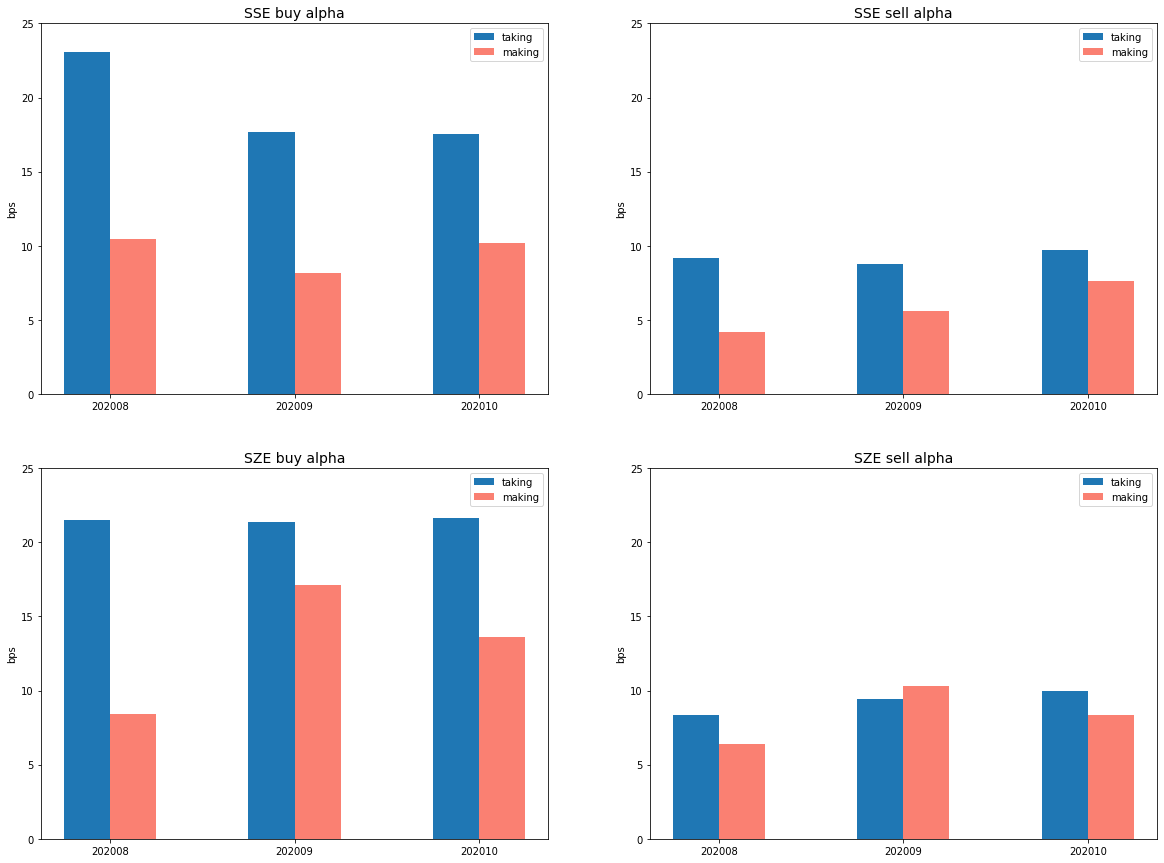

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl

for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
    df2[col] = df2[col].apply(lambda x: x*10000)
df2 = df2.sort_values(by='tag')    

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
width = 0.25
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['buyAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,25)

ax1 = fig.add_subplot(222)
width = 0.25
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['sellAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,25)

ax1 = fig.add_subplot(223)
width = 0.25
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['buyAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,25)

ax1 = fig.add_subplot(224)
width = 0.25
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['sellAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,25)

plt.show()

In [98]:
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', np.where(
df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
display(df[df['sta'] == 'else'])
df1 = df.copy()

df1 = df1[(df1['ars']//1%10 == 1)]

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange","sta"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange","sta"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet"].transform(sum)
df1["sumsellRet1"] = df1["tradeNtl"] * df1["sellRet1"]
df1["sumsellRet1"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet1"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha"].transform(sum)
df1["sumbuyAlpha1"] = df1["tradeNtl"] * df1["buyAlpha1"]
df1["sumbuyAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha1"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha"].transform(sum)
df1["sumsellAlpha1"] = df1["tradeNtl"] * df1["sellAlpha1"]
df1["sumsellAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha1"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet"].transform(sum)
df1["sumbuyRet1"] = df1["tradeNtl"] * df1["buyRet1"]
df1["sumbuyRet1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet1"].transform(sum)

df1["buyRet_90s"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet_90s"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha_90s"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha_90s"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyRet_300s"] = df1["sumbuyRet1"] / df1["sumbuyNtl"]
df1["sellRet_300s"] = df1["sumsellRet1"] / df1["sumsellNtl"]
df1["buyAlpha_300s"] = df1["sumbuyAlpha1"] / df1["sumbuyNtl"]
df1["sellAlpha_300s"] = df1["sumsellAlpha1"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["exchange","sta"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["exchange","sta"])["sellNum"].transform(sum)

df2 = df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().reset_index()

from IPython.display import display, HTML
for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().to_html())

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,l4tr,internalId,session,cfe,orderId,underlyingIndex,mt,hee,cancellationPending,mfe,threadId,ms,finalState,sequenceNo,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,m1,m2,index_name,tag,exchange,sta


In [147]:
(df[(df['sta'] == '3. sta300') & (df['tag'] == 202010) & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))]['sellAlpha'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 10000).astype('int64')

count    117820000
mean            11
std             31
min           -378
10%            -12
20%             -4
30%              0
40%              5
50%              9
60%             14
70%             20
80%             29
90%             44
max            272
Name: sellAlpha, dtype: int64

In [148]:
(df[(df['sta'] == '2. statwo') & (df['tag'] == 202010) & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))]['sellAlpha'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) * 10000).astype('int64')

count    15030680000
mean               7
std               33
min             -856
10%              -19
20%               -7
30%               -1
40%                2
50%                6
60%               11
70%               16
80%               24
90%               39
max              642
Name: sellAlpha, dtype: int64

In [154]:
(df[(df['sta'] == '3. sta300') & (df['tag'] == 202010) & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))].groupby(['date', 'index_name'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
date     index_name                                              
20201014 CSIRest      4880000     8   15  -29    0    6   15   76
20201015 CSIRest      7900000    10   35 -229    0    9   21  116
20201016 CSIRest      8230000     8   39 -180   -4    7   23  272
20201019 CSIRest      8350000     9   30 -293   -3    7   19  166
20201020 CSIRest      5950000    18   31  -69    3   11   26  168
20201021 CSIRest      9630000    11   30 -147   -1    9   24  152
         IC           4050000    12   23  -90    0    7   28   76
20201022 CSIRest      8400000    11   41 -378    0   10   24  161
         IC           3870000     5   24 -113   -4    6   19   57
20201023 CSIRest     10540000    13   28 -191    0    9   26  134
20201026 CSIRest      9410000    12   34 -226    0   11   27  204
20201027 CSIRest      7850000    15   30 -131    1   13   29  211
20201028 CSIRest      8200000    11   31 -234    0    9   22  133
20201029 CSIRest      9020000    15   28 -146    0   12   30  165
20201030 CSIRest     11540000     9   28 -194   -5    6   21  220

In [151]:
(df[(df['sta'] == '2. statwo') & (df['tag'] == 202010) & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))].groupby(['date', 'index_name'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
date     index_name                                               
20201009 CSI1000     157920000     8   29 -345   -2    7   20  186
         CSIRest     236210000     9   34 -239   -2    7   21  345
         IC          130780000     4   27 -225   -5    5   16  163
         IF           48090000    10   26 -131   -3    6   18  154
20201012 CSI1000     204050000     8   31 -422   -2    6   19  297
         CSIRest     319050000     8   36 -369   -3    7   23  321
         IC          156570000     7   24 -291   -2    7   18  151
         IF           58530000    10   27 -155   -1    5   22  195
20201013 CSI1000     174400000     6   30 -273   -2    5   18  174
         CSIRest     273240000     8   46 -484   -3    8   25  244
         IC          151140000     6   27 -153   -1    7   18  233
         IF           47420000     6   23  -94   -5    6   16  130
20201014 CSI1000     261880000     7   28 -175   -2    6   19  319
         CSIRest     406480000     7   34 -620   -3    6   21  395
         IC          191610000     4   25 -155   -3    5   16  154
         IF           89400000     4   26 -255   -4    5   17  169
20201015 CSI1000     284260000     8   29 -248   -3    5   18  243
         CSIRest     422630000    11   41 -679   -3    8   25  323
         IC          192710000     6   22 -120   -2    5   15  182
         IF           72440000     7   21 -122   -1    5   16  107
20201016 CSI1000     305800000     7   24 -228   -3    6   18  315
         CSIRest     429640000     5   38 -536   -5    5   20  291
         IC          183240000     6   25 -181   -3    4   16  150
         IF           84230000     7   25 -176   -3    6   17  137
20201019 CSI1000     272230000     6   26 -216   -4    5   16  232
         CSIRest     376280000     5   44 -835   -6    5   21  242
         IC          131960000     5   27 -120   -4    6   17  131
         IF           69680000     4   22 -116   -5    3   14  127
20201020 CSI1000     244390000     8   28 -283   -2    7   19  173
         CSIRest     358110000    11   40 -561   -2    7   23  379
         IC          149710000     5   20 -204   -3    5   14  113
         IF           58240000     4   23 -123   -5    4   14  110
20201021 CSI1000     306880000     7   28 -243   -3    5   17  642
         CSIRest     459220000     8   36 -760   -4    6   21  298
         IC          164750000     6   25 -157   -3    7   18  141
         IF           92550000     8   26 -134   -3    6   18  153
20201022 CSI1000     315010000     6   27 -226   -3    5   17  201
         CSIRest     480660000     7   38 -856   -5    6   20  376
         IC          189170000     4   24 -148   -4    5   16  166
         IF           73220000     6   24 -121   -3    5   15  262
20201023 CSI1000     324990000     6   23 -219   -4    5   16  223
         CSIRest     484710000     7   39 -623   -5    7   23  444
         IC          214910000     8   22 -102   -3    6   18  139
         IF          116920000     7   23 -113   -3    6   19  140
20201026 CSI1000     276830000     8   28 -175   -3    7   21  270
         CSIRest     487250000     8   40 -482   -5    8   25  331
         IC          194240000     7   23 -144   -3    6   17  260
         IF           65240000     3   29 -204   -5    4   16  142
20201027 CSI1000     219520000     7   32 -292   -4    7   20  325
         CSIRest     358390000     8   56 -675   -6    9   29  399
         IC          145230000     8   28 -167   -4    7   21  132
         IF           90020000     3   24 -161   -5    5   15  117
20201028 CSI1000     279470000     8   28 -208   -3    6   19  282
         CSIRest     412320000     9   37 -381   -4    8   23  389
         IC          233250000     7   21 -165   -3    5   16  176
         IF           79560000     9   29 -134   -3    6   20  174
20201029 CSI1000     317280000     7   28 -216   -2    7   20  186
         CSIRest     481740000     8   40 -558   -3    7   23  251
     

In [119]:
d1 = pd.read_csv(r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs\speedCompare_20201026.csv')

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
d2 = pd.read_pickle(r'L:\orderLog\ret\orderLogWithRet_20201026.pkl')

In [155]:
pd.merge(d1[(d1['updateType'] == 0) & (d1['mrstaat'].isin([11000, 13000])) & (d1['orderDirection'].isin([-1, -2])) & (d1['secid'] > 2000000)], add[add['date'] == 20201026], on='secid')['index_name'].unique()

array(['CSIRest'], dtype=object)

In [132]:
d1[(d1['internalId'] == 6) & (d1['secid'] == 1603786) & (d1['vai'] == 104400)]

,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrstaat,session,cfe,mrss90,mrstauc,mra100,orderId,underlyingIndex,mt,mrsb90,mrm,mrsb300,orderPrice,l4tr,hee,mrb100,cancellationPending,mrss300,mfe,threadId,ms,finalState,sequenceNo,ApplSeqNum,clock,mrstaum
64115,64115,20201026,1.603677e+15,1.603677e+15,zt_52_05,537403,1603786.0,104400.0,95816000.0,1.0,400.0,0.0,-1.00,0.0,0.0,NaN,NaN,0.001944,6.0,1.0,22.0,0.000487,13000.0,0,6784128.74,-0.002107,11000.0,7216.0,-1.0,905,0.0,0.001293,0.000487,0.002242,72.16,0.0,0.001127,7213.0,0.0,-0.002652,0.0,22781.0,09:58:19.842292,0.0,37424179.0,0.0,1.603677e+15,1.0
64116,64116,20201026,1.603678e+15,1.603677e+15,zt_52_05,537403,1603786.0,104400.0,-1.0,1.0,400.0,2.0,-1.00,0.0,0.0,NaN,63930.0,-1.000000,6.0,-1.0,0.0,-1.000000,13000.0,0,6784128.74,-0.002107,11000.0,7216.0,63930.0,905,-1.0,0.001293,0.000487,0.002242,72.16,0.0,-1.000000,7213.0,0.0,-0.002652,0.0,22805.0,09:58:20.074292,0.0,37424179.0,0.0,1.603678e+15,1.0
64117,64117,20201026,1.603678e+15,1.603677e+15,zt_52_05,537403,1603786.0,104400.0,-1.0,1.0,400.0,4.0,72.16,400.0,400.0,4350821.0,NaN,-1.000000,6.0,-1.0,0.0,-1.000000,13000.0,0,6784128.74,-0.002107,11000.0,7216.0,63930.0,905,-1.0,0.001293,0.000487,0.002242,72.16,0.0,-1.000000,7213.0,0.0,-0.002652,0.0,22805.0,09:58:20.137292,1.0,37424179.0,0.0,1.603678e+15,1.0


In [118]:
(df[(df['sta'] == '2. statwo') & (df['tag'] == 202010) & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([1, 2]))].groupby(['date', 'index_name'])['buyAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
date     index_name                                               
20201009 CSI1000     246550000    17   33 -438   -2   12   30  286
         CSIRest     302370000    20   41 -210   -3   14   39  374
         IC          192310000    15   30 -134   -3   10   30  176
         IF           98290000    15   25 -113    0   12   29  137
20201012 CSI1000     219600000    17   37 -195    0   10   28  326
         CSIRest     311080000    25   54 -114   -1   12   38  495
         IC          225100000    17   34 -119   -4    9   34  132
         IF           77010000     9   22 -190   -2    7   20  237
20201013 CSI1000     126800000    18   29  -93    0   12   30  297
         CSIRest     229500000    22   38 -123    0   14   35  356
         IC          102440000    12   27 -119    0    9   21  165
         IF           43670000    17   25  -68    1   15   33  163
20201014 CSI1000     182240000    14   28 -139    0   10   24  271
         CSIRest     290770000    22   45 -301    0   14   37  381
         IC          121290000    12   25 -112   -2    8   23  176
         IF           49900000    15   27 -102    2   14   25  220
20201015 CSI1000     187860000    17   36 -258    0   11   29  404
         CSIRest     283630000    28   59 -402    0   16   40  501
         IC          113490000    15   27 -138    0   10   26  157
         IF           53800000    14   32 -191   -2   12   24  195
20201016 CSI1000     189210000    18   39 -174    0   12   31  290
         CSIRest     300010000    28   53 -287    0   16   41  525
         IC           93720000    16   27  -98    0   13   31  213
         IF           42770000     8   25  -79   -5    7   22  122
20201019 CSI1000     159630000    16   33 -202   -1   11   29  237
         CSIRest     265100000    18   42 -180   -2   13   36  719
         IC           86820000    15   37  -99   -3    8   24  208
         IF           62700000    10   26  -68   -3    8   21  157
20201020 CSI1000     216650000    16   38 -199   -3    8   26  204
         CSIRest     323730000    20   45 -318   -3   13   36  309
         IC          149230000    17   32 -115   -1   10   29  147
         IF           71330000    14   22  -79    1   10   25  132
20201021 CSI1000     183750000    14   27 -127   -1   10   25  361
         CSIRest     333670000    21   41 -218   -1   14   35  321
         IC          113640000    10   19 -138   -1    7   20  170
         IF           57000000     9   22  -77   -3    5   20  143
20201022 CSI1000     200770000    18   38 -161   -1   11   29  294
         CSIRest     366760000    23   47 -239   -2   14   39  730
         IC          149790000    12   26 -120   -2    8   22  253
         IF           63270000    11   26 -233   -1   10   25  158
20201023 CSI1000     202970000    14   30 -294    0   12   27  238
         CSIRest     360310000    20   45 -668    0   15   36  460
         IC          119430000     9   26 -106   -5    8   23  185
         IF           69560000     7   22  -96   -6    6   18  143
20201026 CSI1000     207670000    19   33 -187    0   13   31  275
         CSIRest     352000000    25   55 -330   -2   15   40  402
         IC          140100000    15   28 -161    0   10   26  177
         IF           72610000    12   25 -106   -3   10   27  136
20201027 CSI1000     156880000    13   30 -107   -3    9   26  253
         CSIRest     232740000    15   40 -207   -4   11   32  355
         IC          130300000    16   28 -112    0   10   31  190
         IF           72700000    10   26  -68   -7    9   27  103
20201028 CSI1000     220930000    17   37 -210   -1   11   29  271
         CSIRest     355380000    21   41 -217   -1   14   37  344
         IC          190210000    12   24 -257   -2    8   23  230
         IF           92970000    13   27 -134   -2   11   29  112
20201029 CSI1000     222620000    15   33  -92   -2   10   29  216
         CSIRest     341790000    21   44 -240    0   15   38  375
     

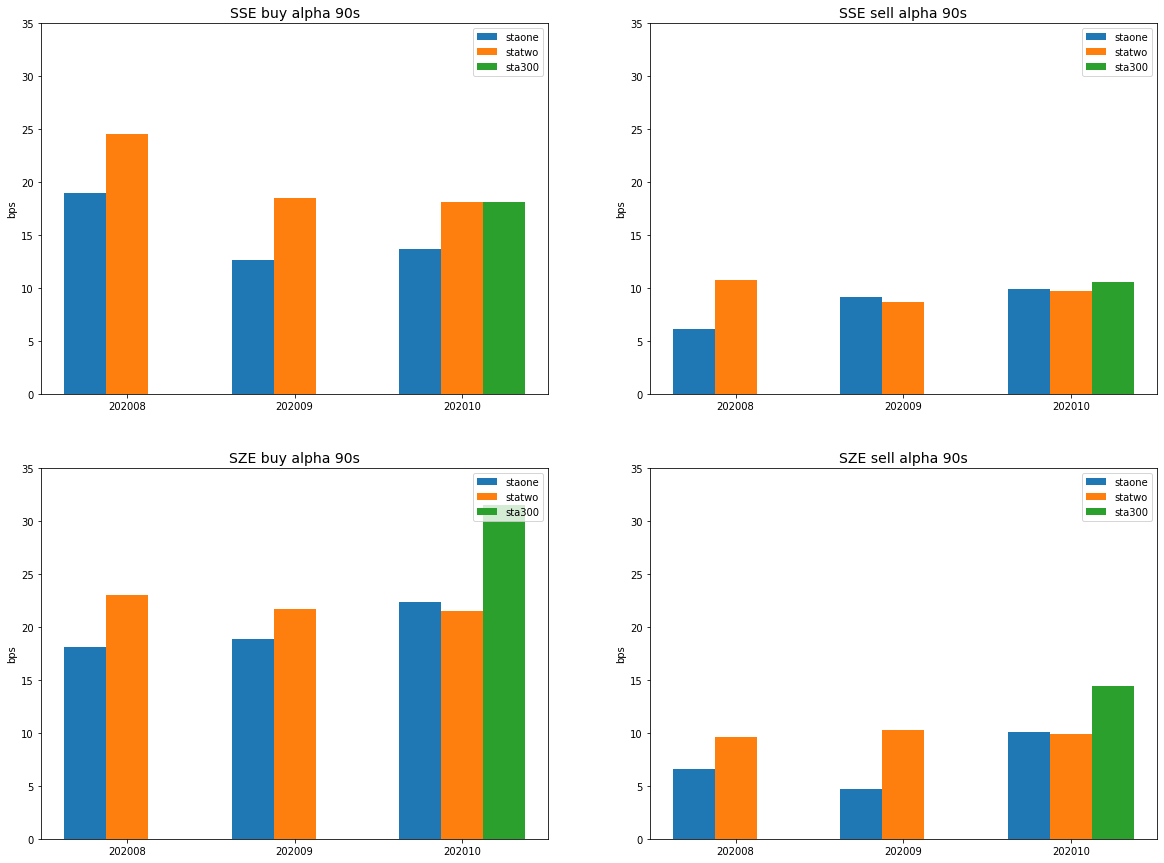

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl

for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df2[col] = df2[col].apply(lambda x: x*10000)
df2 = df2.sort_values(by='tag')    

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyAlpha_90s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyAlpha_90s'], alpha=1, width=width, label='statwo')
list1 = [0, 0]
list1.append(float(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyAlpha_90s']))
ax1.bar(np.arange(3)+width, list1, width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE buy alpha 90s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(222)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellAlpha_90s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellAlpha_90s'], alpha=1, width=width, label='statwo')
list1 = [0, 0]
list1.append(float(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellAlpha_90s']))
ax1.bar(np.arange(3)+width, list1, width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE sell alpha 90s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(223)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyAlpha_90s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyAlpha_90s'], alpha=1, width=width, label='statwo')
list1 = [0, 0]
list1.append(float(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyAlpha_90s']))
ax1.bar(np.arange(3)+width, list1, width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE buy alpha 90s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(224)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellAlpha_90s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellAlpha_90s'], alpha=1, width=width, label='statwo')
list1 = [0, 0]
list1.append(float(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellAlpha_90s']))
ax1.bar(np.arange(3)+width, list1, width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE sell alpha 90s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

plt.show()

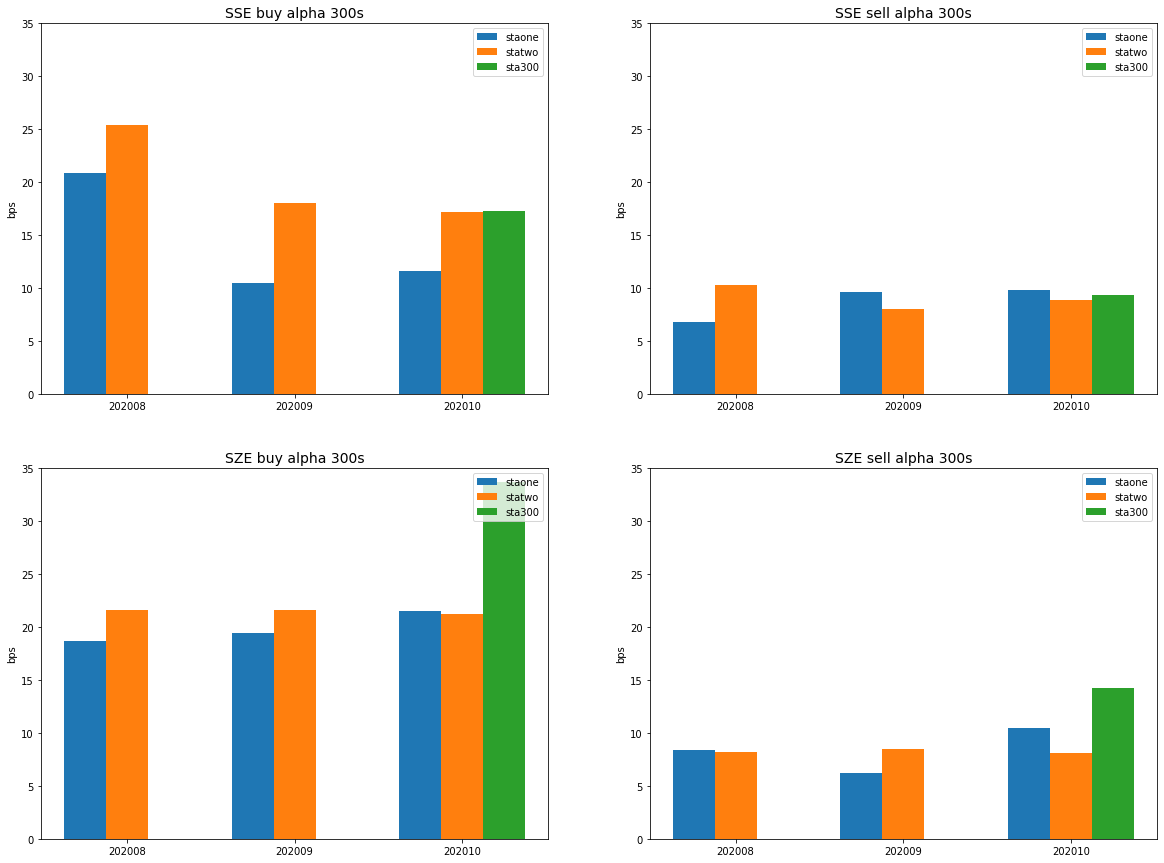

In [108]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyAlpha_300s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyAlpha_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(3)+width, [0, 0] + list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyAlpha_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE buy alpha 300s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(222)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellAlpha_300s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellAlpha_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(3)+width, [0, 0] + list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellAlpha_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE sell alpha 300s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(223)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyAlpha_300s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyAlpha_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(3)+width, [0, 0] + list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyAlpha_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE buy alpha 300s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(224)
width = 0.25
ax1.bar(np.arange(3)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellAlpha_300s'], width = width, label='staone')
ax1.bar(np.arange(3), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellAlpha_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(3)+width, [0, 0] + list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellAlpha_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE sell alpha 300s", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

plt.show()

In [109]:
df1 = df.copy()

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "index_name"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "index_name"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["sellNum"].transform(sum)

df2 = df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()

from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

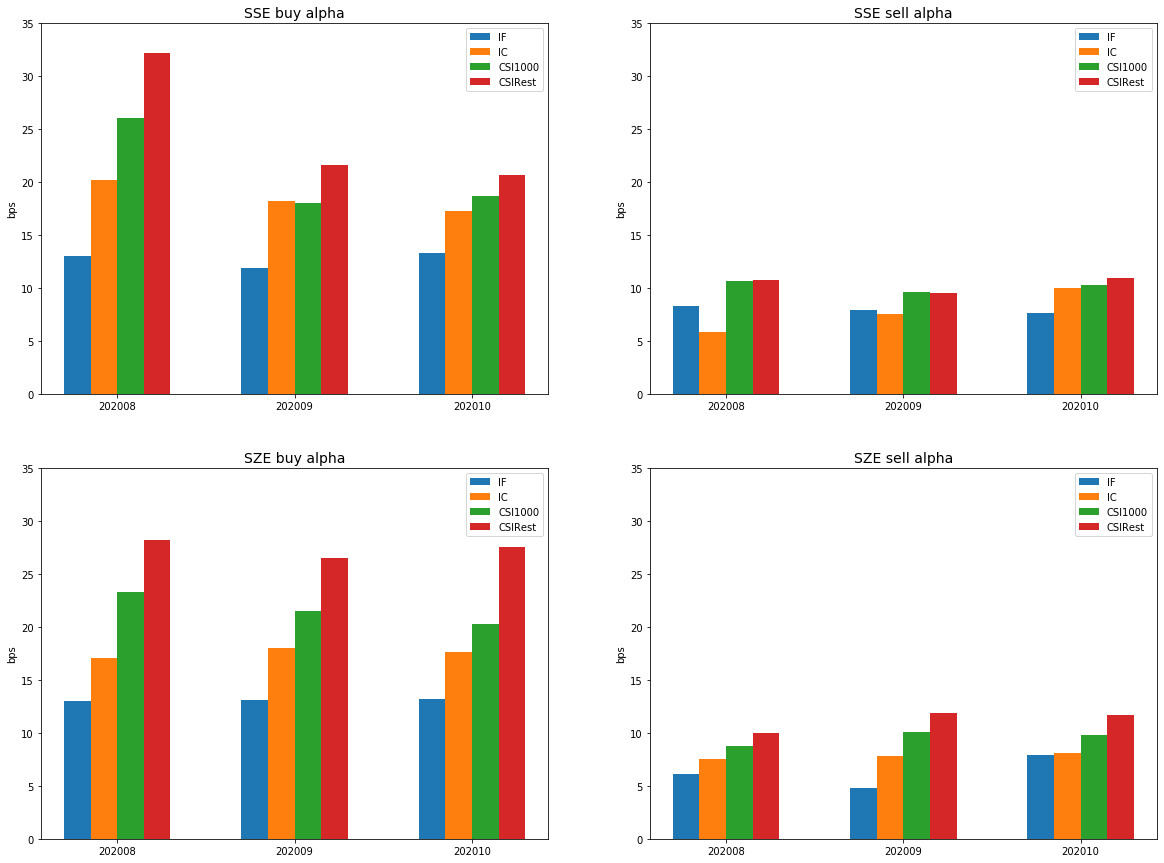

In [112]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

# for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
#     df2[col] = df2[col].apply(lambda x: x*10000)
# df2 = df2.sort_values(by='tag')    

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
width = 0.15
ax1.bar(np.arange(3)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['buyAlpha'], width = width, label='IF')
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['buyAlpha'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['buyAlpha'], width = width, label='CSI1000')
ax1.bar(np.arange(3)+1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['buyAlpha'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(222)
width = 0.15
ax1.bar(np.arange(3)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['sellAlpha'], width = width, label='IF')
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['sellAlpha'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['sellAlpha'], width = width, label='CSI1000')
ax1.bar(np.arange(3)+1.5*width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['sellAlpha'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(223)
width = 0.15
ax1.bar(np.arange(3)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['buyAlpha'], width = width, label='IF')
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['buyAlpha'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['buyAlpha'], width = width, label='CSI1000')
ax1.bar(np.arange(3)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['buyAlpha'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(224)
width = 0.15
ax1.bar(np.arange(3)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['sellAlpha'], width = width, label='IF')
ax1.bar(np.arange(3)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['sellAlpha'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(3)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['sellAlpha'], width = width, label='CSI1000')
ax1.bar(np.arange(3)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['sellAlpha'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

plt.show()

In [74]:
df['tradeNtl'] = df['tradePrice'] * df['absFilledThisUpdate']
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['secid'])['tradeNtl'].sum()

secid
1600006.0      881282.30
1600008.0      508325.40
1600017.0      328128.00
1600021.0      864292.44
1600022.0      881119.05
                ...     
1603883.0     7280139.79
1603885.0     4313372.28
1603888.0     3525068.50
1603939.0    10516785.17
1603983.0     1362322.01
Name: tradeNtl, Length: 243, dtype: float64

In [76]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['secid'])['tradeNtl'].sum()

secid
1600000.0     643619.06
1600004.0    7329315.67
1600009.0    8283121.80
1600011.0    2327351.36
1600015.0    1462662.42
                ...    
1603799.0    6248420.94
1603833.0    5565251.25
1603899.0    5369194.85
1603986.0    8097324.30
1603993.0    2868383.02
Name: tradeNtl, Length: 187, dtype: float64

In [15]:
(df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['tradePrice'] * \
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate']).sum()

1757363328.9

In [16]:
(df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['tradePrice'] * \
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate']).sum()

2812352018.05

In [84]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype(int)

count     65510
mean       1798
std        6503
min           1
10%         100
20%         100
30%         200
40%         300
50%         500
60%         700
70%        1000
80%        1800
90%        3800
max      571700
Name: absFilledThisUpdate, dtype: int32

In [83]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype(int)

count     73647
mean       2474
std        9107
min           1
10%         100
20%         200
30%         200
40%         400
50%         500
60%         900
70%        1200
80%        2102
90%        5000
max      647950
Name: absFilledThisUpdate, dtype: int32

In [82]:
df[df['absFilledThisUpdate'] == 647950.000000]

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,l4tr,internalId,mrstauc,mrstaat,index_name,exchange,sta,tradeNtl
236975,1.596697e+15,1.596697e+15,1601398.0,4.0,198526740.0,11.0,647950.0,-1.0,647950.0,647950.0,5.01,5.01,20200806,9561,0.0,zt_94_02,NaN,2.93347e+07,145537000.0,-1.0,0.0,-0.003631,-1.0,-0.002751,0.000759,199174690.0,501.0,502.0,31033,0.0,1,28660,1.596697e+15,1000300,0.512719,1.596697e+15,1.596697e+15,5.005627,5.02,5.012525,4762.0022,4761.1433,4762.1205,4762.7642,NaN,NaN,-0.001992,-0.000504,0.000025,0.00016,NaN,NaN,-0.001979,-0.000422,0,1,zt9402_9561,0.0,756.0,0.0,1000.0,IF,SSE,1. staone,3246229.5


In [26]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['sellAlpha'].sum()

34.84893405118365

In [27]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['sellAlpha'].sum()

51.323704684801946

In [31]:
(df[(df['index_name'] == 'IC') & (df['exchange'] == 'SZE') & (~df1["sellRet"].isnull())]['tradePrice'] * \
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SZE') & (~df1["sellRet"].isnull())]['absFilledThisUpdate'] * \
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SZE') & (~df1["sellRet"].isnull())]['sellAlpha']).sum() / 1374412422.03

0.0008368972795787763

In [28]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['sellAlpha'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    65510.000000
mean         0.000532
std          0.003241
min         -0.054175
10%         -0.001948
20%         -0.000882
30%         -0.000329
40%          0.000083
50%          0.000495
60%          0.000949
70%          0.001489
80%          0.002230
90%          0.003394
max          0.045087
Name: sellAlpha, dtype: float64

In [91]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby('date')['secid'].nunique()

date
20200803    121
20200804    136
20200805    141
20200806    135
20200807    148
20200810    116
20200811    124
20200812    135
20200813    121
20200814    141
20200817    150
20200818    161
20200819    158
20200820    142
20200821    162
20200824    139
20200825    121
20200826    168
20200827    147
20200828    150
20200831    141
Name: secid, dtype: int64

In [90]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby('date')['secid'].nunique()

date
20200803     71
20200804    102
20200805     95
20200806    100
20200807    111
20200810     87
20200811     96
20200812     91
20200813     67
20200814     98
20200817    103
20200818     82
20200819     96
20200820    102
20200821    115
20200824     99
20200825    110
20200826    108
20200827     99
20200828    117
20200831    113
Name: secid, dtype: int64

In [73]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['date', 'order'])['accCode'].size().describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype('int64')

count    25665
mean         2
std          4
min          1
10%          1
20%          1
30%          1
40%          1
50%          1
60%          2
70%          2
80%          3
90%          5
max        281
Name: accCode, dtype: int64

In [75]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['date', 'order'])['accCode'].size().describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype('int64')

count    17868
mean         4
std          7
min          1
10%          1
20%          1
30%          1
40%          1
50%          2
60%          2
70%          3
80%          5
90%          9
max        210
Name: accCode, dtype: int64

In [8]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['date', 'order'])['accCode'].size().describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype('int64')

count    106693
mean          2
std           3
min           1
10%           1
20%           1
30%           1
40%           1
50%           1
60%           1
70%           2
80%           2
90%           4
max          99
Name: accCode, dtype: int64

In [9]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby(['date', 'order'])['accCode'].size().describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype('int64')

count    62959
mean         2
std          4
min          1
10%          1
20%          1
30%          1
40%          1
50%          1
60%          1
70%          2
80%          3
90%          5
max        261
Name: accCode, dtype: int64

In [99]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate'].sum()

182227494.0

In [98]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())]['absFilledThisUpdate'].sum()

117799506.0

In [15]:
df[(df['index_name'] == 'IF') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby('date')['accCode'].nunique()

date
20201014    7
20201015    8
20201016    9
20201019    9
20201020    9
20201021    9
20201022    9
20201023    9
20201026    9
20201027    9
20201028    9
20201029    9
20201030    9
Name: accCode, dtype: int64

In [14]:
df[(df['index_name'] == 'IC') & (df['exchange'] == 'SSE') & (~df["sellRet"].isnull())].groupby('date')['accCode'].nunique()

date
20201014    17
20201015    19
20201016    19
20201019    18
20201020    20
20201021    20
20201022    20
20201023    18
20201026    18
20201027    20
20201028    19
20201029    20
20201030    20
Name: accCode, dtype: int64

### 2. plot

In [4]:
# 1. making/taking
readPath = "L:\\orderLog\\monthly return\\***\\taking_making.csv"
dataPathLs = np.array(glob.glob(readPath))
df = []
for i in dataPathLs:
    data = pd.read_csv(i)
    df += [data]
df = pd.concat(df)

In [5]:
df

,exchange,order_type,buyOrderNum,buyRet,buyAlpha,sellOrderNum,sellRet,sellAlpha
0,SSE,making_order,1908,10.40,8.08,2299,13.32,9.26
1,SSE,taking_order,80166,23.95,21.57,122597,12.56,9.10
2,SZE,making_order,4820,12.31,10.51,6336,11.59,7.26
3,SZE,taking_order,135539,22.73,20.75,202397,12.46,8.58
0,SSE,making_order,12946,10.00,9.03,17066,6.85,6.11
1,SSE,taking_order,249706,18.90,17.46,403952,11.12,9.09
2,SZE,making_order,22221,18.47,16.88,28779,11.86,10.47
3,SZE,taking_order,520912,22.70,21.16,761405,12.27,9.86
0,SSE,making_order,3114,11.52,11.72,3168,6.88,7.66
1,SSE,taking_order,336676,18.07,16.94,520135,10.88,9.63


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


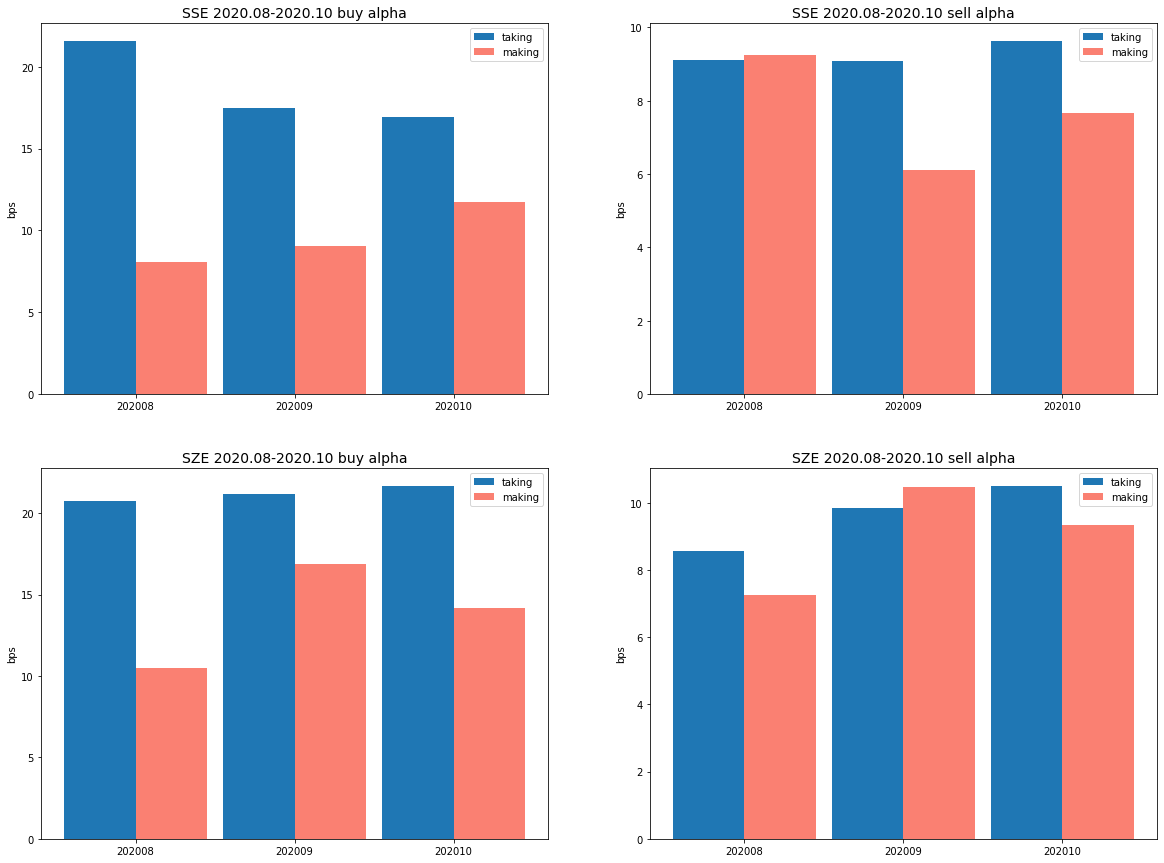

In [13]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
width = 0.45
ax1.bar(np.arange(3)-width/2, df[(df['exchange'] == 'SSE') & (df['order_type'] == 'taking_order')]['buyAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df[(df['exchange'] == 'SSE') & (df['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE 2020.08-2020.10 buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1 = fig.add_subplot(222)
width = 0.45
ax1.bar(np.arange(3)-width/2, df[(df['exchange'] == 'SSE') & (df['order_type'] == 'taking_order')]['sellAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df[(df['exchange'] == 'SSE') & (df['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SSE 2020.08-2020.10 sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1 = fig.add_subplot(223)
width = 0.45
ax1.bar(np.arange(3)-width/2, df[(df['exchange'] == 'SZE') & (df['order_type'] == 'taking_order')]['buyAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df[(df['exchange'] == 'SZE') & (df['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE 2020.08-2020.10 buy alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax1 = fig.add_subplot(224)
width = 0.45
ax1.bar(np.arange(3)-width/2, df[(df['exchange'] == 'SZE') & (df['order_type'] == 'taking_order')]['sellAlpha'], width = width, label='taking')
ax1.bar(np.arange(3)+width/2, df[(df['exchange'] == 'SZE') & (df['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(3), ['202008', '202009', '202010'])
plt.title("SZE 2020.08-2020.10 sell alpha", fontsize=14)
ax1.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()